In [23]:
# Simulation of MRAC control adding voltage bias to controllable VV/VW curves

In [24]:
import pycigar
import pandas as pd
import numpy as np
from pycigar.utils.input_parser import input_parser

In the code block below, we use `input_parser` to get the basic configuration of the experiment.
- `benchmark=True`: set the std of inverter filters to 0, disable the randomness in the environment.
- `vectorized_mode=True`: solve the PQ injection of all inverters in vectorized mode, we expect to cut down 50% of execution time vs `vectorized_mode=False`. To be able to run, we need `scipy==1.5.2`. I updated it in the requirements but you may need to reinstall it if you use the old pycigar conda env.
- The adversarial inverters always use `adaptive_fixed_controller`.

## Register new controller to PyCIGAR
To add a custom controller, we need to register it with PyCIGAR.
Assume that we now have the new controller as in here: `pycigar/controllers/custom_adaptive_inverter_controller.py`, now we want to register it with PyCIGAR.

In [25]:
from pycigar.utils.registry import register_devcon
from pycigar.controllers.MRAC_adaptive_controller import MRAC_adaptive_controller
from pycigar.controllers.adaptive_inverter_controller import AdaptiveInverterController
from pycigar.controllers.custom_hack_controller import CustomHackController
from pycigar.controllers.fixed_controller import FixedController

In [26]:
register_devcon('Attacker', CustomHackController)
register_devcon('Defender', MRAC_adaptive_controller)

'Defender'

In [27]:
file_misc_inputs_path = pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv'

This is where we change experiment parameters

In [28]:
misc_inputs = pd.read_csv(pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv', index_col=0, header=None, names=['parameter', 'value'])
misc_inputs.value['hack start']=250
misc_inputs.value['hack end']=2000
misc_inputs.value['hack update']=4000
misc_inputs.value['measurement filter time constant mean']=1
misc_inputs.value['measurement filter time constant avg v']=10
misc_inputs.value['gamma']=0.2  #control=0.1
misc_inputs.value['k']=0
#misc_inputs.Value['solar scaling factor']=1.5
misc_inputs.to_csv(pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv', header=None)

hack = 0.0
nodes_hack = ['s722b', 's712c', 's727c', 's738a', 's736b', 's730c', 's729a', 's725b', 's728']
#nodes_no_pv = ['s724b', 's732c', 's740c', 's731b']

In [29]:
env.k.node.nodes.keys()

dict_keys(['s701a', 's701b', 's701c', 's712c', 's713c', 's714a', 's714b', 's718a', 's720c', 's722b', 's722c', 's724b', 's725b', 's727c', 's728', 's729a', 's730c', 's731b', 's732c', 's733a', 's734c', 's735c', 's736b', 's737a', 's738a', 's740c', 's741c', 's742a', 's742b', 's744a'])

In [16]:
misc_inputs = pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv'
dss = pycigar.DATA_DIR + '/ieee37busdata/ieee37.dss'
load_solar = pycigar.DATA_DIR + '/ieee37busdata/load_solar_data.csv'
breakpoints = pycigar.DATA_DIR + '/ieee37busdata/breakpoints.csv'

sim_params = input_parser(misc_inputs, dss, load_solar, breakpoints, benchmark=True, percentage_hack=hack, vectorized_mode=False)
start = 100
sim_params['scenario_config']['start_end_time'] = [start, start + 1500]  # fix the exp start and end time
for node in sim_params['scenario_config']['nodes']:
    if node['name'] in nodes_hack:
        node['devices'][0]['hack'] = [250.0, 1.0, 2000.0]

# for node in sim_params['scenario_config']['nodes']:
#     if node['name'] in nodes_no_pv:
#         node['devices'] = []

sim_params['env_config']['sims_per_step'] = 1 # on 1 step call, it is equal to 1 simulation step.
del sim_params['attack_randomization'] # turn off the attack randomization

from pycigar.envs.norl_env import NoRLEnv
env = NoRLEnv(sim_params=sim_params) # init env with the sim_params above

env.reset()
done = False
while not done:
    done = env.step() # every step call will return done, the status whether the exp is finished or not

All the information of the experiment has been logged in the `logger` of PyCIGAR.
The `logger` has 2 dictionaries:
- `logger().log_dict`: a dictionary has all informations of inverters/nodes.
- `logger().custom_metric`: a dictionary has custom metric (substation power,...) 

In [17]:
env.k.node.nodes['s724b']

{'voltage': array([0.94185291, 0.94186276, 0.95021696, ..., 0.98991257, 0.98972354,
        0.98947798]),
 'load': array([37.44390203, 37.46331897, 37.48926976, ..., 36.7666327 ,
        36.68462403, 36.73663073]),
 'PQ_injection': {'P': 0, 'Q': 0}}

In [18]:
from pycigar.utils.logging import logger
Logger = logger()

#print(Logger.log_dict.keys())

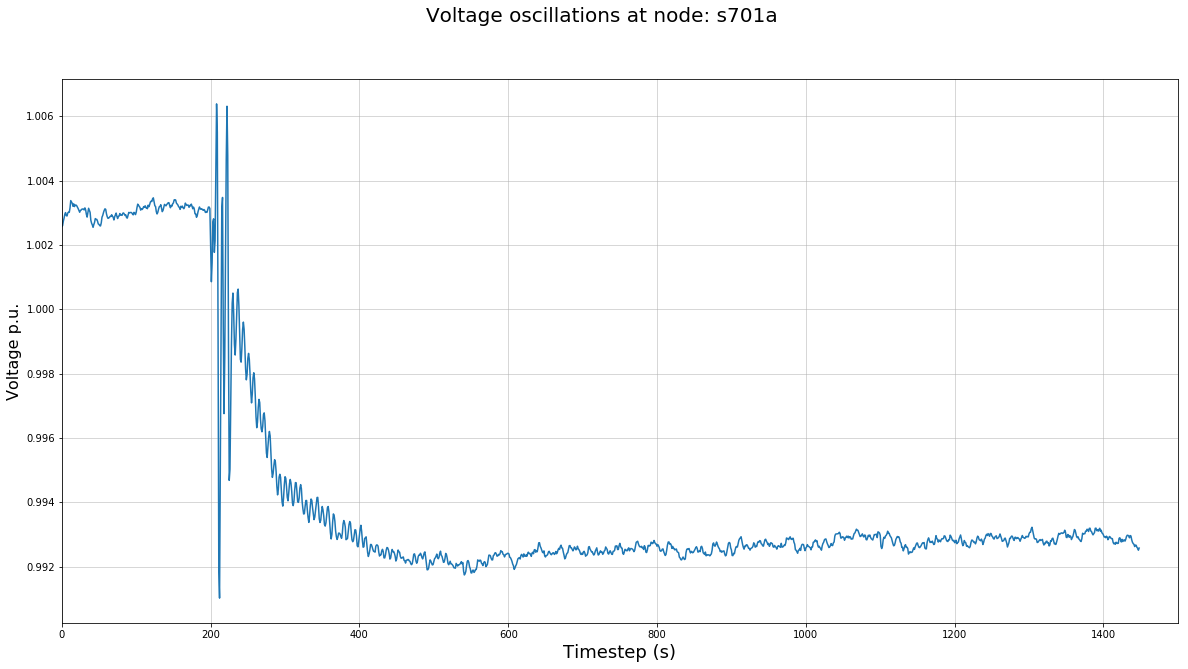

In [19]:
import matplotlib.pyplot as plt 
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
node_id = 's701a'
f.suptitle('Voltage oscillations at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
ax.plot(Logger.log_dict[node_id]['voltage'])
plt.savefig("voltage_bias.png")
plt.show()

In [20]:
total_cap = 0
hack_cap = 0
for device_id, device in env.k.device.devices.items():
    if 'reg' not in device_id:
        if 'adversary' in device_id:
            hack_cap += env.k.device.devices[device_id]['device'].Sbar
        total_cap += env.k.device.devices[device_id]['device'].Sbar

print(hack_cap/total_cap)

0.2962453888157481


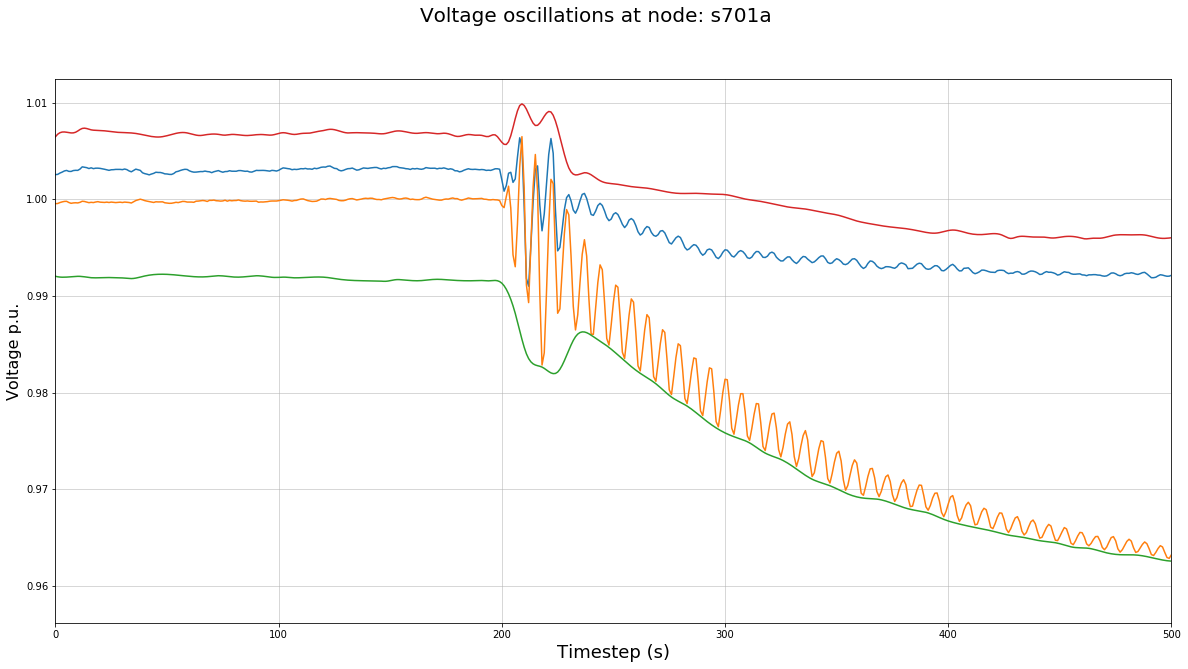

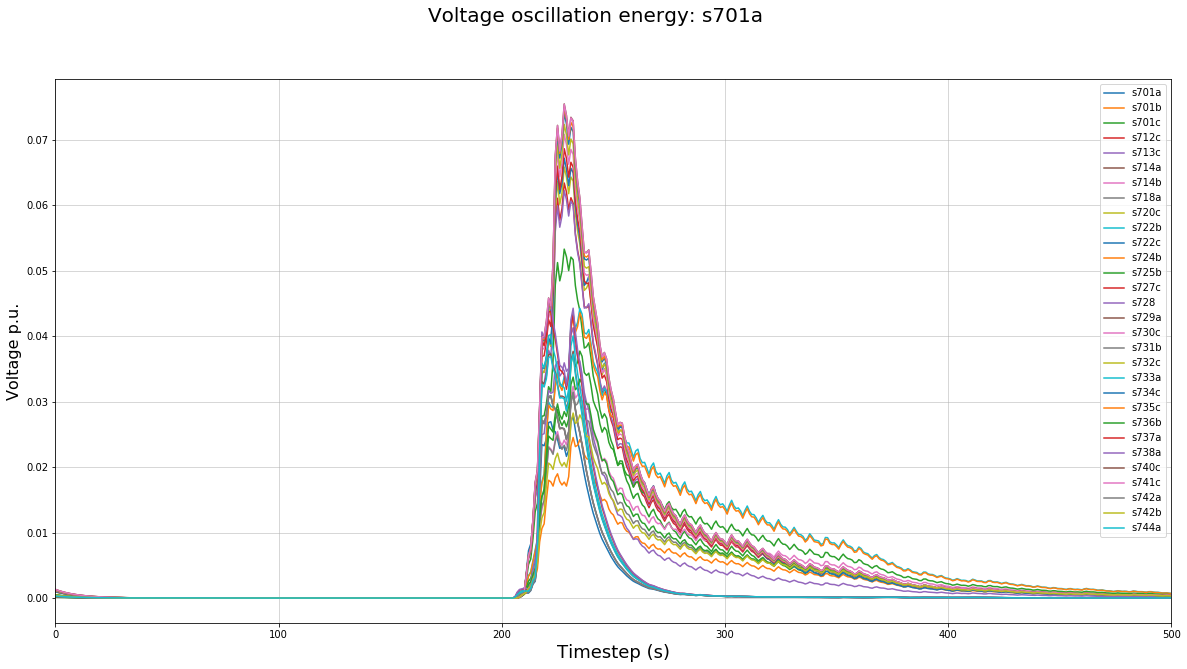

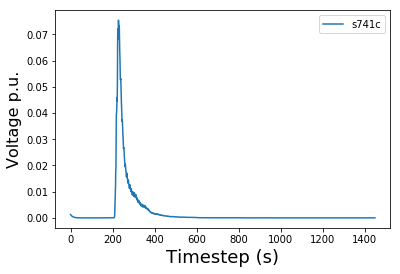

In [31]:
from scipy.interpolate import interp1d
def envelope(signal):
    s = np.array(signal) #This is your noisy vector of values.

    q_u = np.zeros(s.shape)
    q_l = np.zeros(s.shape)

    #Prepend the first value of (s) to the interpolating values. This forces the model to use the same starting point for both the upper and lower envelope models.

    u_x = [0,]
    u_y = [s[0],]

    l_x = [0,]
    l_y = [s[0],]

    #Detect peaks and troughs and mark their location in u_x,u_y,l_x,l_y respectively.

    for k in range(1,len(s)-1):
        if (np.sign(s[k]-s[k-1])==1) and (np.sign(s[k]-s[k+1])==1):
            u_x.append(k)
            u_y.append(s[k])

        if (np.sign(s[k]-s[k-1])==-1) and ((np.sign(s[k]-s[k+1]))==-1):
            l_x.append(k)
            l_y.append(s[k])

    #Append the last value of (s) to the interpolating values. This forces the model to use the same ending point for both the upper and lower envelope models.

    u_x.append(len(s)-1)
    u_y.append(s[-1])

    l_x.append(len(s)-1)
    l_y.append(s[-1])

    #Fit suitable models to the data. Here I am using cubic splines, similarly to the MATLAB example given in the question.

    u_p = interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)
    l_p = interp1d(l_x,l_y,kind = 'cubic',bounds_error = False, fill_value=0.0)

    #Evaluate each model over the domain of (s)
    for k in range(0,len(s)):
        q_u[k] = u_p(k)
        q_l[k] = l_p(k)

    #Plot everything
    return q_u, q_l

from pycigar.utils.logging import logger
Logger = logger()

import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(20, 10))

nodes = [node for node in Logger.log_dict.keys() if node[0] == 's']
inverters = [inverter for inverter in Logger.log_dict.keys() if 'inverter' in inverter]
all_voltages = []
all_y = []
for node_id in nodes:
    all_voltages.append(Logger.log_dict[node_id]['voltage'])
for inverter_id in inverters:
    all_y.append(Logger.log_dict[inverter_id]['y'])
all_voltages = np.array(all_voltages)

#all_voltages_mean = np.mean(all_voltages[0:100], axis=1)
#all_voltages -= all_voltages_mean.reshape(30,1)
min_voltage = np.min(all_voltages, axis=0)
max_voltage = np.max(all_voltages, axis=0)

_, min_bound = envelope(min_voltage)
max_bound, _ = envelope(max_voltage)

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 500])

node_id = 's701a'
f.suptitle('Voltage oscillations at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
ax.plot(Logger.log_dict[node_id]['voltage'])
ax.plot(Logger.log_dict['s741c']['voltage'])
#ax.plot(all_voltages[0])
ax.plot(min_bound)
ax.plot(max_bound)
plt.show()

f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 500])
min_y = np.min(all_y, axis=0)
max_y = np.max(all_y, axis=0)
mean_y = np.mean(all_y, axis=0)
std_y = np.std(all_y, axis=0)
f.suptitle('Voltage oscillation energy: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
#ax.plot(max_y)
#ax.plot(min_y)
#ax.plot(mean_y)
#ax.plot(mean_y + std_y)
#ax.plot(mean_y - std_y)
for node_id in nodes:
    plt.plot(Logger.log_dict['inverter_' + node_id]['y'], label=node_id)
plt.legend()
plt.show()

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 500])
min_y = np.min(all_y, axis=0)
max_y = np.max(all_y, axis=0)
mean_y = np.mean(all_y, axis=0)
std_y = np.std(all_y, axis=0)
percentile_25 = np.percentile(all_y, 25, axis=0)
percentile_75 = np.percentile(all_y, 75, axis=0)
f.suptitle('Voltage oscillation energy: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
#ax.plot(max_y)
#ax.plot(min_y)
#ax.plot(mean_y)
#ax.plot(mean_y + std_y)
#ax.plot(mean_y - std_y)
node_id = 's741c'
plt.plot(Logger.log_dict['inverter_' + node_id]['y'], label=node_id)
plt.legend()
plt.show()


In [33]:
node_id = 's701a'
xmax = 600
voltage_csv = {}
y_csv = {}
for node_id in nodes:
    voltage_csv[node_id] = np.asarray(Logger.log_dict[node_id]['voltage'][0:xmax]).reshape(-1,1)
    y_csv['inverter_{}'.format(node_id)] = np.asarray(Logger.log_dict['inverter_{}'.format(node_id)]['y'][0:xmax]).reshape(-1,1)
min_bound_csv = np.asarray(min_bound[0:xmax]).reshape(-1,1)
max_bound_csv = np.asarray(max_bound[0:xmax]).reshape(-1,1)
max_y_csv = np.asarray(max_y[0:xmax]).reshape(-1,1)
min_y_csv = np.asarray(min_y[0:xmax]).reshape(-1,1)
mean_y_csv = np.asarray(mean_y[0:xmax]).reshape(-1,1)
std_y_csv = np.asarray(std_y[0:xmax]).reshape(-1,1)
percentile_25_csv = np.asarray(percentile_25[0:xmax]).reshape(-1,1)
percentile_75_csv = np.asarray(percentile_75[0:xmax]).reshape(-1,1)

time_vec = np.arange(0,xmax).reshape(-1,1)
data = np.concatenate((time_vec, min_bound_csv, max_bound_csv, max_y_csv, min_y_csv, mean_y_csv, std_y_csv, percentile_25_csv, percentile_75_csv,*list(voltage_csv.values()), *list(y_csv.values())), axis=1)
df = pd.DataFrame(data, columns=['Time', 'min_bound_voltage', 'max_bound_volgage', 'max_y', 'min_y', 'mean_y', 'std_y', 'percent_25', 'percent_75',*list(voltage_csv.keys()), *list(y_csv.keys())])

df.to_csv("30_bounded_voltage_bias_voltage" + node_id + "_control_hete.csv")
#df.to_csv("bounded_voltage_bias_voltage" + node_id + "_no_control.csv")

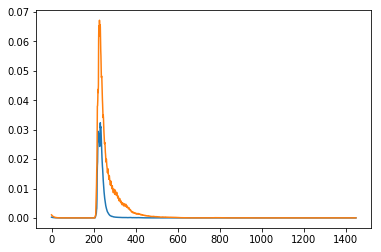

In [32]:
plt.plot(percentile_25)
plt.plot(percentile_75)

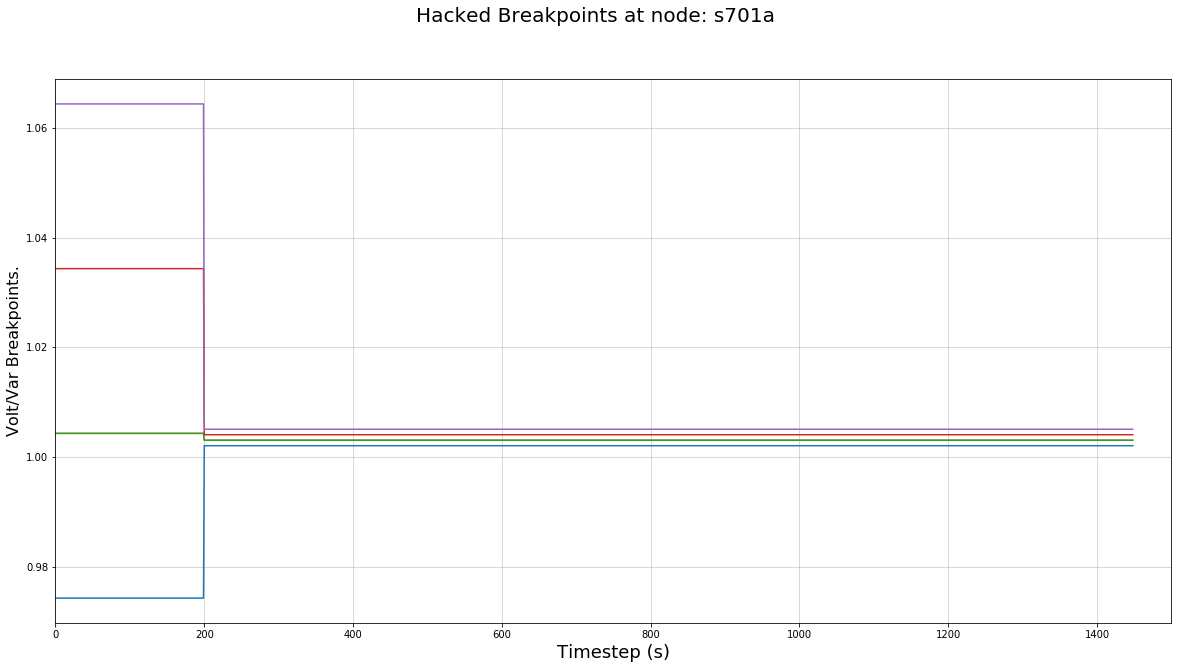

In [10]:
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
key = 'adversary_inverter_s701a'
f.suptitle('Hacked Breakpoints at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Volt/Var Breakpoints.', fontsize=16)
ax.plot(Logger.log_dict[key]['control_setting'])
plt.show()

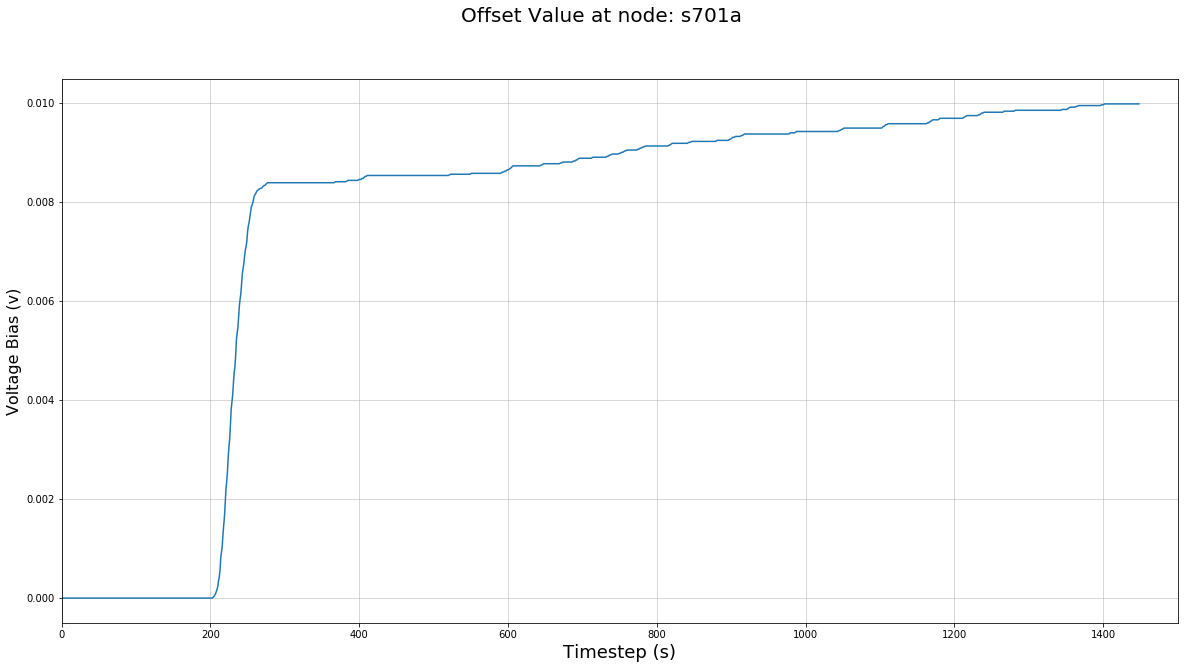

In [11]:
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
key = 'inverter_s701a'
f.suptitle('Offset Value at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage Bias (v)', fontsize=16)
ax.plot(Logger.log_dict[key]['y'])
plt.show()

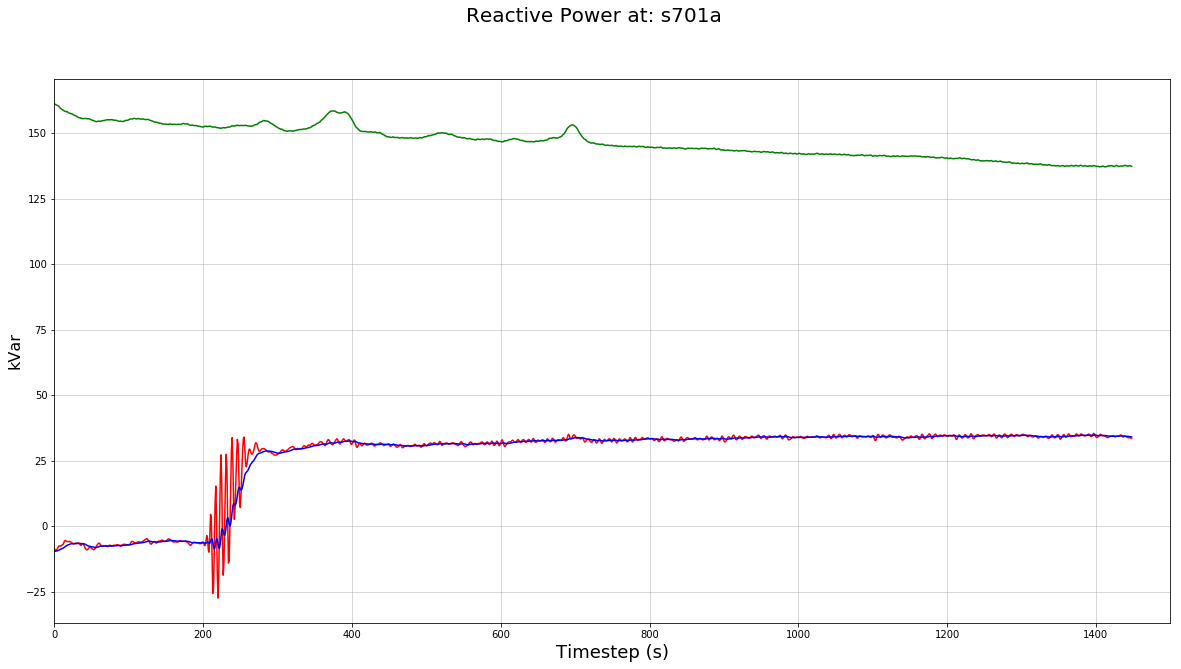

In [12]:
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
f.suptitle('Reactive Power at: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('kVar', fontsize=16)
key = 'inverter_s701a'
ax.plot(Logger.log_dict[key]['q_set'], 'r')
ax.plot(Logger.log_dict[key]['q_out'], 'b')
ax.plot(Logger.log_dict[key]['q_bar'], 'g')
plt.show()

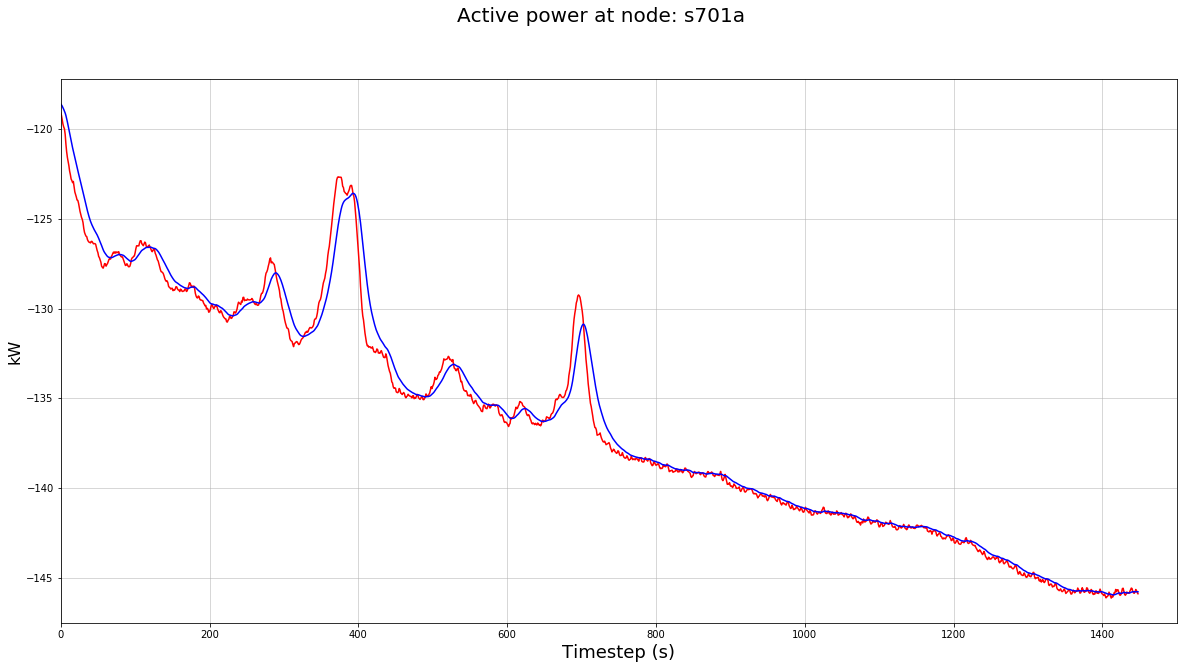

In [13]:
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
f.suptitle('Active power at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('kW', fontsize=16)
key = 'inverter_s701a'
ax.plot(Logger.log_dict[key]['p_set'], 'r')
ax.plot(Logger.log_dict[key]['p_out'], 'b')
plt.show()

In [14]:
# Substation power and reactive power

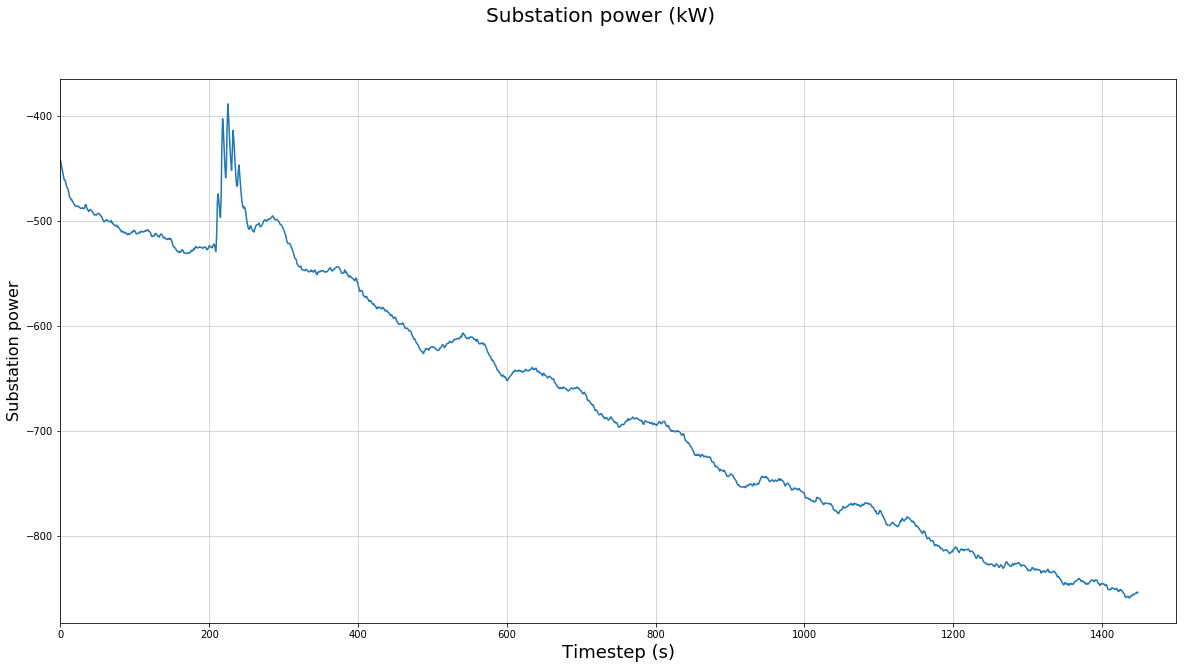

In [17]:
from pycigar.utils.logging import logger
Logger = logger()

import matplotlib.pyplot as plt 
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
node_id = 's701a'
f.suptitle('Substation power (kW)', fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Substation power', fontsize=16)
ax.plot(np.array(Logger.log_dict['network']['substation_power'])[:, 0])
plt.show()

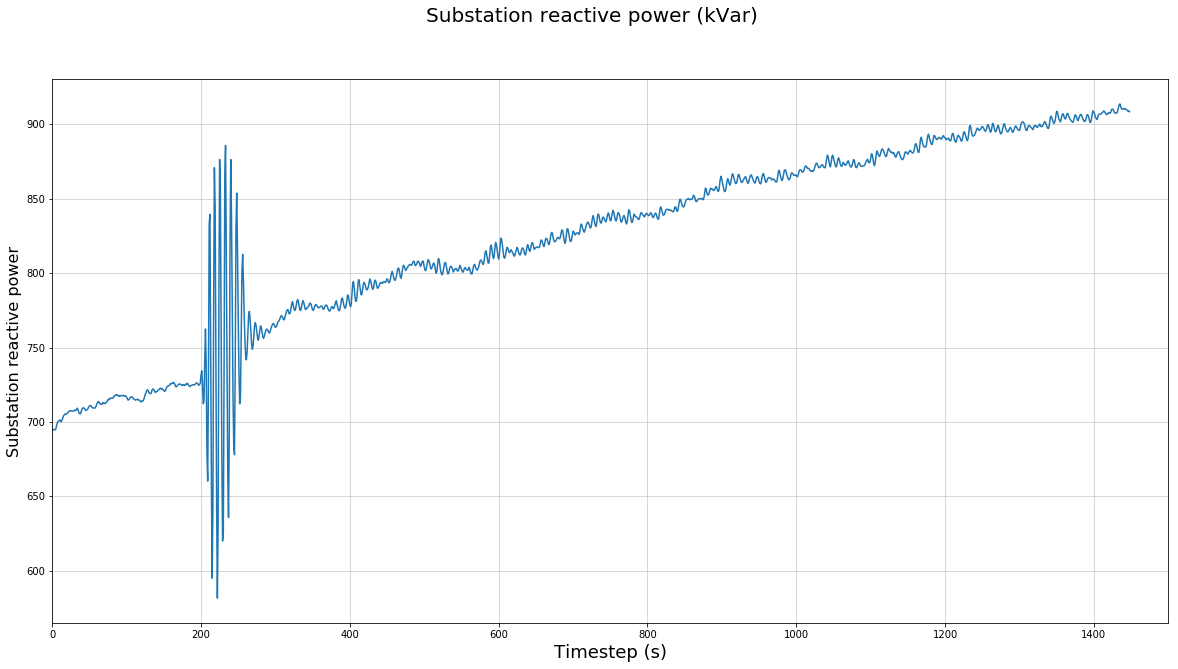

In [18]:
from pycigar.utils.logging import logger
Logger = logger()

import matplotlib.pyplot as plt 
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
node_id = 's701a'
f.suptitle('Substation reactive power (kVar)', fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Substation reactive power', fontsize=16)
ax.plot(np.array(Logger.log_dict['network']['substation_power'])[:, 1])
plt.show()